In [8]:
import time
from src.method_selector import MlMethodSelector, ClassicMethodSelector
from src.measurement_provider import MeasurementProvider
from src.serializer import SenMLCBORSerializer, SenMLJSONSerializer
from src.signal_generator import SignalGenerator
from sys import getsizeof
from src.metric import FeatureMetricEnum, SimilarityMetricEnum
from src.data_type import Measurement
import pandas as pd
import matplotlib as plt
from src.metric import SimilarityMetricEnum
import random
plt.rcParams["figure.dpi"] = 150
pd.set_option('display.max_columns', None)

In [9]:
def compute_sizes(dataset, compressed_data, metrics):
  senML_cbor_size_original = getsizeof(SenMLCBORSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_cbor_size_compressed = getsizeof(SenMLCBORSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_cbor_size_diff = senML_cbor_size_original - senML_cbor_size_compressed
  senML_cbor_size_ratio = senML_cbor_size_diff / senML_cbor_size_original

  senML_json_size_original = getsizeof(SenMLJSONSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_json_size_compressed = getsizeof(SenMLJSONSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_json_size_diff = senML_json_size_original - senML_json_size_compressed
  senML_json_size_ratio = senML_json_size_diff / senML_json_size_original
  return {
    'senML_cbor_size_original': senML_cbor_size_original,
    'senML_cbor_size_compressed': senML_cbor_size_compressed,
    'senML_cbor_size_diff': senML_cbor_size_diff,
    'senML_cbor_size_ratio': senML_cbor_size_ratio,

    'senML_json_size_original': senML_json_size_original,
    'senML_json_size_compressed': senML_json_size_compressed,
    'senML_json_size_diff': senML_json_size_diff,
    'senML_json_size_ratio': senML_json_size_ratio,
  }

def current_milis():
  return time.time() * 1000
  
def run_measurements(dataset, get_measurements):
  ml_method_selector = MlMethodSelector()
  # ml_method_selector.use_default_strategy([
  #   SimilarityMetricEnum.arithmetic_average,
  #   SimilarityMetricEnum.median,
  #   SimilarityMetricEnum.covariance,
  # ])
  ml_method_selector.set_measurements(dataset)
  score = ml_method_selector.train()
  print(score)

  naive_method_selector = ClassicMethodSelector()

  print("datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio")

  results = {
    "datasize": [],
    "ml_time": [],
    "naive_time": [],
    "ml_compressed_size": [],
    "naive_compressed_size": [],
    "ml_compression_ratio": [],
    "naive_compression_ratio": [],
    "ml_method": [],
    "naive_method": [],
    "ml_score": [],
    "naive_score": [],
    "ml_cbor_original_size": [],
    "ml_cbor_compressed_size": [],
    "ml_cbor_compressratio": [],
    "naive_cbor_original_size": [],
    "naive_cbor_compressed_size": [],
    "naive_cbor_compressratio": [],
    "ml_json_original_size": [],
    "ml_json_compressed_size": [],
    "ml_json_compressratio": [],
    "naive_json_original_size": [],
    "naive_json_compressed_size": [],
    "naive_json_compressratio": [],
  }

  for datasize in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # measurements = measurement_provider.to_measurements(SignalGenerator(0, datasize).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2))
    measurements = get_measurements(datasize)

    time_start = current_milis()
    compressed_data, stats, metrics = ml_method_selector.compress_with_best(measurements)
    # print("ML")
    # print(metrics)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)
    metrics_score = ClassicMethodSelector().compute_similarity_with_default_strategy(measurements, compressed_data)

    ml_time = time_end - time_start
    ml_compressed_size = stats['compressed_size']
    ml_compression_ratio = stats['compression_rate'] * 100
    ml_method = stats['method_name']
    ml_score = metrics_score
    ml_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    ml_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    ml_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    ml_json_original_size = serialized_data_stats['senML_json_size_original']
    ml_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    ml_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['datasize'].append(datasize);
    results['ml_time'].append(ml_time);
    results['ml_compressed_size'].append(ml_compressed_size);
    results['ml_compression_ratio'].append(ml_compression_ratio);
    results['ml_method'].append(ml_method);
    results['ml_score'].append(ml_score);
    results['ml_cbor_original_size'].append(ml_cbor_original_size);
    results['ml_cbor_compressed_size'].append(ml_cbor_compressed_size);
    results['ml_cbor_compressratio'].append(ml_cbor_compressratio);
    results['ml_json_original_size'].append(ml_json_original_size);
    results['ml_json_compressed_size'].append(ml_json_compressed_size);
    results['ml_json_compressratio'].append(ml_json_compressratio);

    ##############################################

    time_start = current_milis()
    compressed_data, stats, metrics, metrics_score = naive_method_selector.compress_with_best_default_strategy(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)

    naive_time = time_end - time_start
    naive_compressed_size = stats['compressed_size']
    naive_compression_ratio = stats['compression_rate'] * 100
    naive_method = stats['method_name']
    naive_score = metrics_score
    naive_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    naive_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    naive_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    naive_json_original_size = serialized_data_stats['senML_json_size_original']
    naive_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    naive_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['naive_time'].append(naive_time);
    results['naive_compressed_size'].append(naive_compressed_size);
    results['naive_compression_ratio'].append(naive_compression_ratio);
    results['naive_method'].append(naive_method);
    results['naive_score'].append(naive_score);
    results['naive_cbor_original_size'].append(naive_cbor_original_size);
    results['naive_cbor_compressed_size'].append(naive_cbor_compressed_size);
    results['naive_cbor_compressratio'].append(naive_cbor_compressratio);
    results['naive_json_original_size'].append(naive_json_original_size);
    results['naive_json_compressed_size'].append(naive_json_compressed_size);
    results['naive_json_compressratio'].append(naive_json_compressratio);

    print(f'{datasize},{ml_time},{naive_time},{ml_compressed_size},{naive_compressed_size},{ml_compression_ratio},{naive_compression_ratio},{ml_method},{naive_method},{ml_score},{naive_score},{ml_cbor_original_size},{ml_cbor_compressed_size},{ml_cbor_compressratio},{naive_cbor_original_size},{naive_cbor_compressed_size},{naive_cbor_compressratio},{ml_json_original_size},{ml_json_compressed_size},{ml_json_compressratio},{naive_json_original_size},{naive_json_compressed_size},{naive_json_compressratio}')
  return pd.DataFrame.from_dict(results)

In [10]:
dataset = MeasurementProvider().get_random3()
# df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).linear(2.5).sin(1, 0.2)))
df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).with_peaks(4).with_peaks(3, direction=-1).sin(2, 0.2).linear(0.05).noise()))

(0.4666666666666667, 0.6666666666666666)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,4.655029296875,114.093017578125,70,70,30.0,30.0,CompressPIP_PD_0.7,CompressPIP_PD_0.7,81.7166,81.7166,2323,1724,0.2578562204046492,2323,1724,0.2578562204046492,5390,3878,0.2805194805194805,5390,3878,0.2805194805194805
200,5.5810546875,287.2138671875,20,120,90.0,40.0,CompressPIP_PD_0.1,CompressPIP_ED_0.6,78.987,83.0874,4323,725,0.832292389544298,4323,2725,0.3696507055285681,10541,1413,0.8659519969642349,10486,6429,0.3868968148006866
300,8.194091796875,508.179931640625,90,90,70.0,70.0,CompressPIP_PD_0.3,

In [11]:
# SignalGenerator(0, 100).with_peaks(4).with_peaks(3, direction=-1).sin(2, 0.2).noise().linear(0.05).draw()

In [12]:
# df = pd.read_csv('./results1a.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [13]:
df1 = df
# df = df1
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,4.655029,114.093018,70,70,30.000000,30.0,CompressPIP_PD_0.7,CompressPIP_PD_0.7,81.7166,81.7166,2323,1724,0.257856,2323,1724,0.257856,5390,3878,0.280519,5390,3878,0.280519
1,200,5.581055,287.213867,20,120,90.000000,40.0,CompressPIP_PD_0.1,CompressPIP_ED_0.6,78.9870,83.0874,4323,725,0.832292,4323,2725,0.369651,10541,1413,0.865952,10486,6429,0.386897
2,300,8.194092,508.179932,90,90,70.000000,70.0,CompressPIP_PD_0.3,CompressPIP_PD_0.3,88.5033,88.5033,6324,2125,0.663978,6324,2125,0.663978,15687,4950,0.684452,15687,4950,0.684452
3,400,6.661133,804.708984,41,120,89.750000,70.0,CompressNTHS_0.1,CompressPIP_PD_0.3,76.0646,87.8276,8324,1145,0.862446,8324,2725,0.672633,20901,2519,0.879479,20806,6477,0.688696
4,500,6.709961,1165.030762,51,50,89.800000,90.0,CompressNTHS_0.1,CompressPIP_ED_0.1,71.6053,83.6973,10324,1345,0.869721,10324,1325,0.871658,26042,3013,0.884302,25976,2903,0.888243
5,600,7.240967,1657.489014,61,360,89.833333,40.0,CompressNTHS_0.1,CompressPIP_ED_0.6,74.3671,84.3531,12324,1545,0.874635,12324,7525,0.389403,31254,3571,0.885743,31118,18795,0.396009
6,700,8.008057,2092.703125,71,210,89.857143,70.0,CompressNTHS_0.1,CompressPIP_PD_0.3,70.2512,86.4809,14412,1755,0.878226,14412,4550,0.684291,36358,4069,0.888085,36294,11143,0.692980
7,800,8.487061,2629.915771,81,240,89.875000,70.0,CompressNTHS_0.1,CompressPIP_PD_0.3,67.4119,84.0020,16612,1975,0.881110,16612,5202,0.686853,41496,4598,0.889194,41436,12707,0.693334
8,900,9.069824,3262.224121,91,270,89.888889,70.0,CompressNTHS_0.1,CompressPIP_PD_0.3,76.7275,86.0599,18812,2195,0.883319,18812,5864,0.688284,46566,5055,0.891444,46547,14218,0.694545
9,1000,9.774170,3943.089844,101,500,89.900000,50.0,CompressNTHS_0.1,CompressPIP_ED_0.5,78.9373,86.2056,21012,2415,0.885066,21012,10652,0.493052,51647,5541,0.892714,51629,25996,0.496485


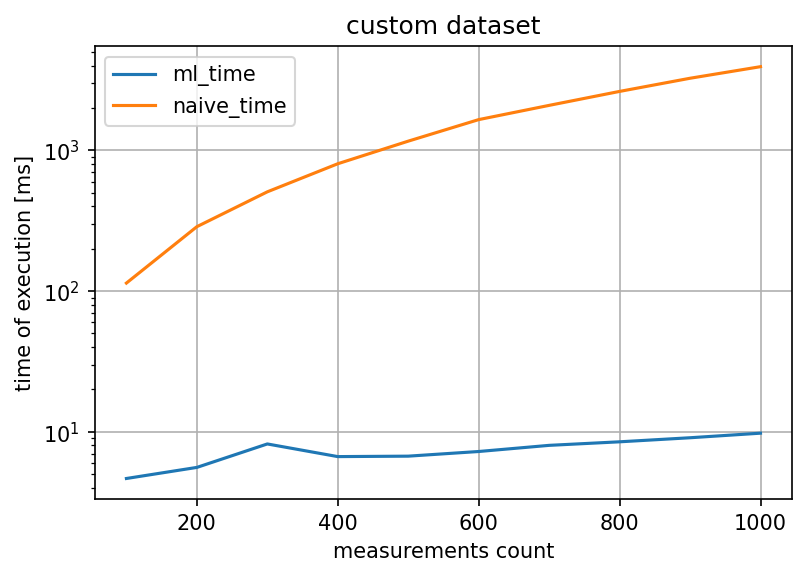

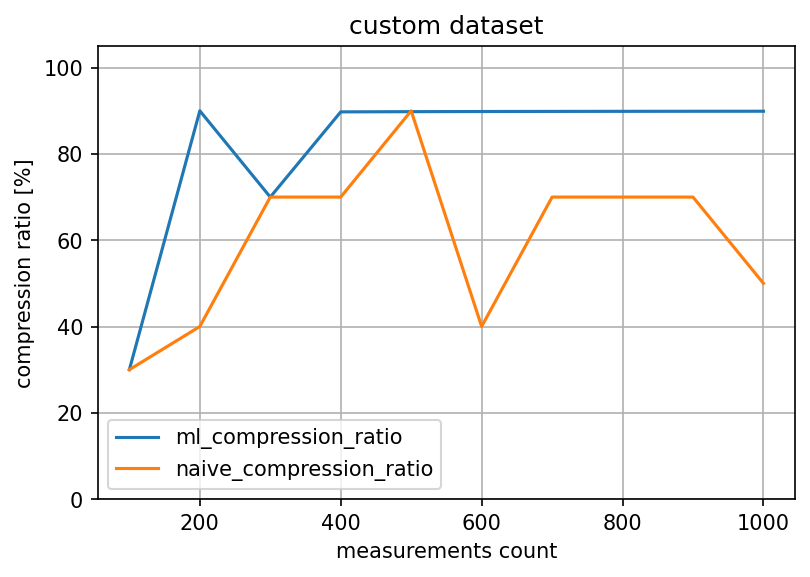

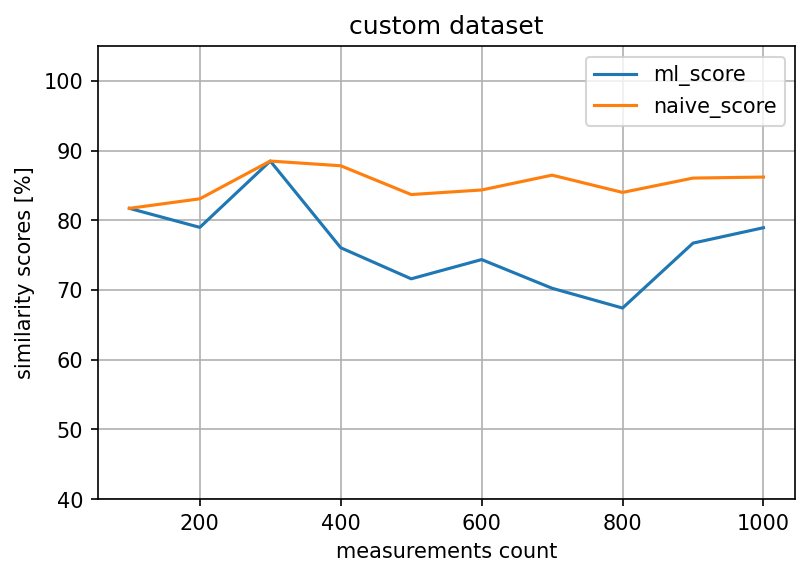

In [14]:
path = '../plot/strategy1RF'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1a.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(0, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2a.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3a.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(40, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4a.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5a.png')


In [15]:
measurements1 = MeasurementProvider().json_to_measurements('stock1.json')
size1 = len(measurements1)
dataset = []
for i in range(10):
  start = int(random.randint(0, size1) * 0.7)
  end = random.randint(start, size1)
  dataset.append(measurements1[start:end])
df = run_measurements(dataset, lambda datasize: MeasurementProvider().json_to_measurements('stock1.json')[:datasize])

(1.0, 1.0)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,4.165283203125,106.283935546875,30,30,70.0,70.0,CompressPIP_PD_0.3,CompressPIP_ED_0.3,77.8161,84.9808,2529,989,0.608936338473705,2529,989,0.608936338473705,5742,1989,0.6536050156739812,5710,1955,0.6576182136602452
200,5.4580078125,273.031982421875,60,20,70.0,90.0,CompressPIP_PD_0.3,CompressPIP_PD_0.1,89.4758,91.8993,4729,1649,0.6513004863607528,4729,769,0.8373863396066822,11120,3561,0.6797661870503597,11119,1405,0.8736397158017807
300,6.981689453125,485.206298828125,90,60,70.0,80.0,CompressPIP_PD_0.3,CompressPIP_PD_0.2,86.4236,87.8

In [16]:
# df = pd.read_csv('./results1b.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [17]:
df2 = df
# df = df2
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,4.165283,106.283936,30,30,70.0,70.0,CompressPIP_PD_0.3,CompressPIP_ED_0.3,77.8161,84.9808,2529,989,0.608936,2529,989,0.608936,5742,1989,0.653605,5710,1955,0.657618
1,200,5.458008,273.031982,60,20,70.0,90.0,CompressPIP_PD_0.3,CompressPIP_PD_0.1,89.4758,91.8993,4729,1649,0.651300,4729,769,0.837386,11120,3561,0.679766,11119,1405,0.873640
2,300,6.981689,485.206299,90,60,70.0,80.0,CompressPIP_PD_0.3,CompressPIP_PD_0.2,86.4236,87.8324,6930,2309,0.666811,6930,1649,0.762049,16530,5176,0.686872,16530,3555,0.784936
3,400,8.685059,764.172119,120,80,70.0,80.0,CompressPIP_PD_0.3,CompressPIP_PD_0.2,84.0544,87.3798,9130,2969,0.674808,9130,2089,0.771194,21998,6843,0.688926,21967,4651,0.788273
4,500,9.921143,1037.846191,150,100,70.0,80.0,CompressPIP_PD_0.3,CompressPIP_PD_0.2,86.6313,88.7511,11330,3629,0.679700,11330,2529,0.776787,27366,8415,0.692502,27366,5707,0.791457
5,600,11.246094,1427.757324,180,60,70.0,90.0,CompressPIP_PD_0.3,CompressPIP_PD_0.1,85.5020,88.1431,13530,4289,0.683001,13530,1649,0.878123,32901,10114,0.692593,32900,3615,0.890122
6,700,12.740967,1853.063965,210,140,70.0,80.0,CompressPIP_PD_0.3,CompressPIP_PD_0.2,86.8413,87.2276,15730,4949,0.685378,15730,3409,0.783280,38265,11688,0.694551,38264,7888,0.793853
7,800,14.095215,2323.385742,240,240,70.0,70.0,CompressPIP_PD_0.3,CompressPIP_ED_0.3,84.7866,88.0099,17930,5610,0.687117,17930,5610,0.687117,43730,13372,0.694214,43702,13341,0.694728
8,900,15.101074,2839.197998,180,180,80.0,80.0,CompressPIP_PD_0.2,CompressPIP_ED_0.2,87.1070,88.1140,20130,4289,0.786935,20130,4289,0.786935,49238,10115,0.794569,49223,10098,0.794852
9,1000,16.531982,3383.223877,200,100,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,91.7016,92.7007,22330,4729,0.788222,22330,2529,0.886744,54743,11188,0.795627,54744,5745,0.895057


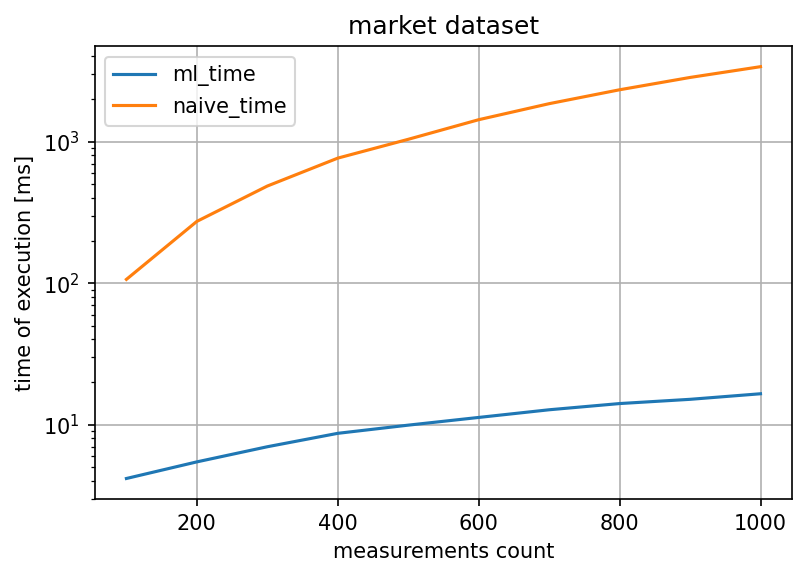

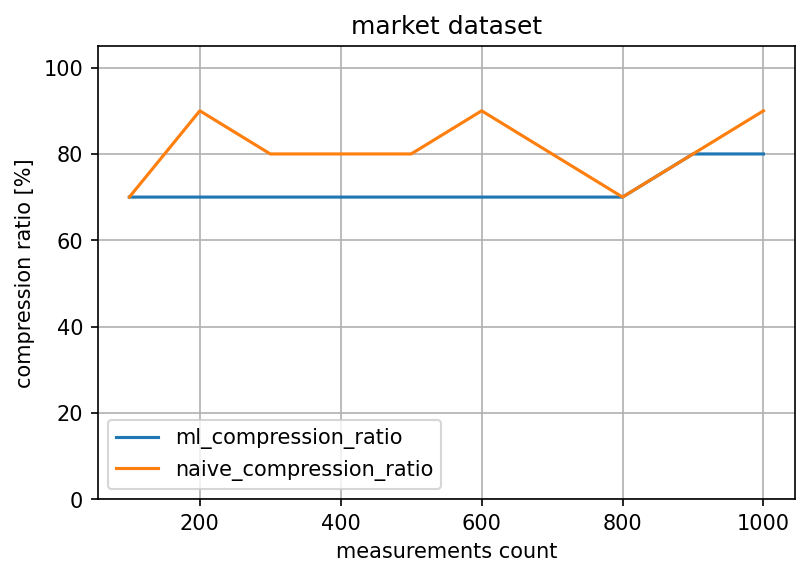

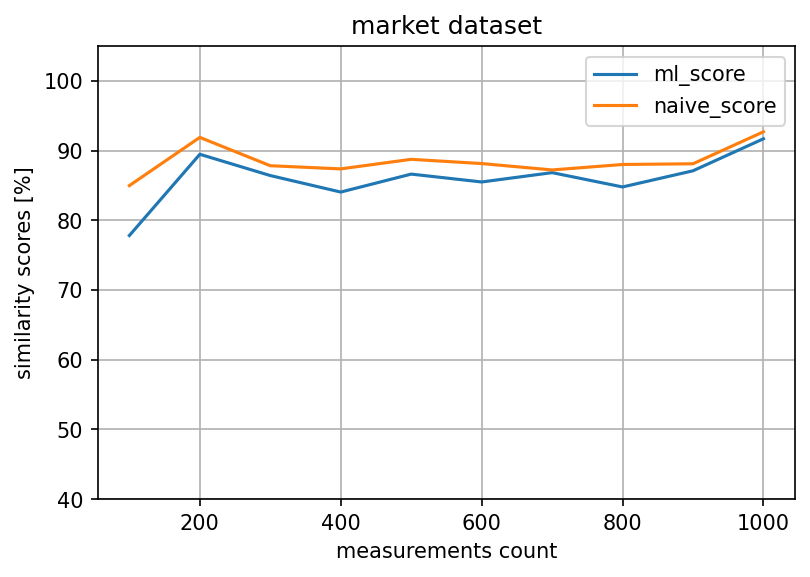

In [18]:
path = '../plot/strategy1RF'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1b.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(0, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2b.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3b.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(40, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4b.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5b.png')
